# TensorLayer Intro Tutorial
by John DeJesus 

This is the notebook for the [TensorLayer Introduction Tutorial Video](https://www.youtube.com/watch?v=sDKH2452IR8&feature=youtu.be&hd=1).<br>
You may read this on its own or follow along with the video.

## From this tutorial you will learn

* What TensorLayer is and its benefits.
* How to build an Artifical Neural Network using TensorLayer.

###  What is TensorLayer? 
[TensorLayer](https://tensorlayer.readthedocs.io/en/stable/) is a Deep Learning library built on TensorFlow. The network construction is similar to Keras but takes components from TensorFlow to still integrate the graph structure.

In [1]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorlayer as tl
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler

%matplotlib inline

Data Source: [Adult Income Census Data](https://archive.ics.uci.edu/ml/datasets/Adult)

In [2]:
# Load the data
adults_train = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data')

In [3]:
# Create columns since columns did not exist. Used from source of data.
adults_train.columns =['Age','WorkClass','Fnlwgt','Education','EducationNum','MartialStatus','Occupation',
                      'Relationship','Race','Sex','CapitalGain','CapitalLoss','HoursPerWeek','NativeCountry','SalaryCategory']

#### **Note**
Since the tutorial is focused on TensorLayer implementation, we are going to just take the numeric data and feature-engineer the SalaryCategory Column. In reality you should feature engineer the categorical values and feature scale the numeric data.<br> 
You should also apply feature selection to see if all the columns are truly necessary for the classifier.
We will also not do a complete exploratory data analysis of the data for the same reason.

### Removing the Categorical Columns

In [4]:
adults_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
Age               32560 non-null int64
WorkClass         32560 non-null object
Fnlwgt            32560 non-null int64
Education         32560 non-null object
EducationNum      32560 non-null int64
MartialStatus     32560 non-null object
Occupation        32560 non-null object
Relationship      32560 non-null object
Race              32560 non-null object
Sex               32560 non-null object
CapitalGain       32560 non-null int64
CapitalLoss       32560 non-null int64
HoursPerWeek      32560 non-null int64
NativeCountry     32560 non-null object
SalaryCategory    32560 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
# Get list of categorical 
def remove_cat_columns(data):
    categorical_columns = []
    for column in data.columns:
        if data[column].dtype == 'O' and column != 'SalaryCategory':
            categorical_columns.append(column)
    return categorical_columns

categorical_columns = remove_cat_columns(adults_train)

In [6]:
# Remove Categorical columns for training
adults_train_filtered = adults_train.drop(categorical_columns, axis=1)

In [7]:
# Check head of data to confirm categorical column removal
adults_train_filtered.head()

,Age,Fnlwgt,EducationNum,CapitalGain,CapitalLoss,HoursPerWeek,SalaryCategory
0,50,83311,13,0,0,13,<=50K
1,38,215646,9,0,0,40,<=50K
2,53,234721,7,0,0,40,<=50K
3,28,338409,13,0,0,40,<=50K
4,37,284582,14,0,0,40,<=50K


### Feature Engineering the Numeric Data and Labels

In [8]:
# Separate Input data from Labels
X = adults_train_filtered.drop(['SalaryCategory'],axis=1).values
y = adults_train_filtered['SalaryCategory'].values

In [9]:
# Binarize SalaryCategory Column
lb = LabelBinarizer()
y_lb= lb.fit_transform(y)

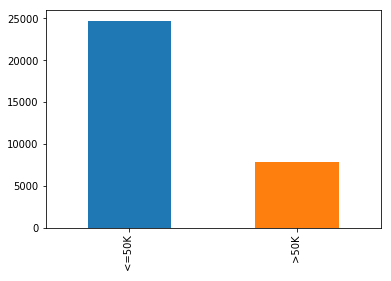

In [10]:
# Visualize the count of our labels
adults_train_filtered.SalaryCategory.value_counts().plot.bar()

So our classification results will not be optimal since our data is very imbalanced. Most of the people in this data file make less than or equal to 50K.

In [11]:
# MinMaxScale the input data
mms = MinMaxScaler()
X_scaled = mms.fit_transform(X)

C:\Users\Sabal\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [12]:
# Check shape for inputs
X_scaled.shape

(32560, 6)

In [13]:
# Check shape of target values vector
y_lb.shape

(32560, 1)

In [14]:
# Flatten the target values vector
y_lb = y_lb.flatten()

In [15]:
# See new shape of target values vector
y_lb.shape

(32560,)

Great! Now we are set to learn how to implement our TensorLayer ANN!

## TensorLayer Model Construction

In [16]:
# Initialize hyperparameters
learning_rate = 0.001
num_hidden = 6
num_outputs = 2
batch_size = 300
n_epoch = 500
print_freq = 5

In [17]:
# Reset the graph
tf.reset_default_graph()

In [18]:
# Set up placeholders
x = tf.placeholder(tf.float32, shape=[None,6], name='x')
y_ = tf.placeholder(tf.int64,shape=[None,], name='y_')

In [19]:
# Initiate interactive session
sess = tf.InteractiveSession()

In [20]:
# create a variable for the relu function
act = tf.nn.relu

In [21]:
# Build the network
network = tl.layers.InputLayer(x, name='input')
network = tl.layers.DenseLayer(network, n_units=num_hidden, act=act, name='h1')
network = tl.layers.DenseLayer(network, n_units=num_hidden, act=act, name='h2')
network = tl.layers.DenseLayer(network, n_units=num_hidden, act=act, name='h3')
network = tl.layers.DenseLayer(network, n_units=num_outputs, act=tf.identity, name='output')

[TL] InputLayer  input: (?, 6)
[TL] DenseLayer  h1: 6 relu
[TL] DenseLayer  h2: 6 relu
[TL] DenseLayer  h3: 6 relu
[TL] DenseLayer  output: 2 No Activation


In [22]:
# Set up cost and metric
y = network.outputs
cost = tl.cost.cross_entropy(y, y_, name='cross_entropy')
correct_prediction = tf.equal(tf.argmax(y,1),y_)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.int64))
y_op = tf.argmax(tf.nn.softmax(y),1)

In [23]:
# Set up optimizer
train_params = network.all_params
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(cost, var_list=train_params)

In [24]:
# Initialize all variables in the session
sess.run(tf.global_variables_initializer())

In [25]:
# Fit the model
tl.utils.fit(sess, network, train_op, cost, X_scaled, y_lb, x, y_, acc=accuracy,
             n_epoch=n_epoch, print_freq=print_freq,
            eval_train=False)

[TL] Start training the network ...
[TL] Epoch 1 of 500 took 0.405915s, loss 1.291261
[TL] Epoch 5 of 500 took 0.292311s, loss 0.563682
[TL] Epoch 10 of 500 took 0.316157s, loss 0.551165
[TL] Epoch 15 of 500 took 0.365024s, loss 0.511147
[TL] Epoch 20 of 500 took 0.301195s, loss 0.440265
[TL] Epoch 25 of 500 took 0.269859s, loss 0.417860
[TL] Epoch 30 of 500 took 0.303189s, loss 0.411469
[TL] Epoch 35 of 500 took 0.332114s, loss 0.409205
[TL] Epoch 40 of 500 took 0.296206s, loss 0.407935
[TL] Epoch 45 of 500 took 0.297157s, loss 0.407661
[TL] Epoch 50 of 500 took 0.301194s, loss 0.407478
[TL] Epoch 55 of 500 took 0.269281s, loss 0.407869
[TL] Epoch 60 of 500 took 0.265290s, loss 0.407115
[TL] Epoch 65 of 500 took 0.259306s, loss 0.407285
[TL] Epoch 70 of 500 took 0.264293s, loss 0.407402
[TL] Epoch 75 of 500 took 0.261236s, loss 0.407309
[TL] Epoch 80 of 500 took 0.292220s, loss 0.406821
[TL] Epoch 85 of 500 took 0.282289s, loss 0.407436
[TL] Epoch 90 of 500 took 0.265289s, loss 0.4070

In [26]:
# get predictions
y_pred = tl.utils.predict(sess, network, X_scaled, x=x, y_op=y_op)

In [27]:
# evaluate the predictions
results = tl.utils.evaluation(y_lb,y_pred, n_classes=2)

[TL] confusion matrix: 
[[23528  1191]
 [ 4841  3000]]
[TL] f1-score        : [0.88637734 0.49867021]
[TL] f1-score(macro) : 0.692524
[TL] accuracy-score  : 0.814742


# Apply Test Data to Model

In [28]:
# load the test data
adults_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', header=1)

In [29]:
# check test data head
adults_test.head()

,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0.1,40,United-States,<=50K.
0,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
1,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
2,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
3,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K.


In [30]:
# Assign Proper Columns
adults_test.columns = adults_train.columns

In [31]:
# Remove categorical Columns
categorical_columns = remove_cat_columns(adults_test)
adults_test_filtered = adults_test.drop(categorical_columns, axis=1)

In [32]:
# Separate test inputs from test labels
X_test = adults_test_filtered.drop(['SalaryCategory'], axis=1).values
y_test = adults_test_filtered['SalaryCategory'].values

In [33]:
# Transform test inputs with minmaxscaler
X_test_scaled = mms.transform(X_test)

In [34]:
# Binarize test labels
y_test_lb = lb.fit_transform(y_test).flatten()

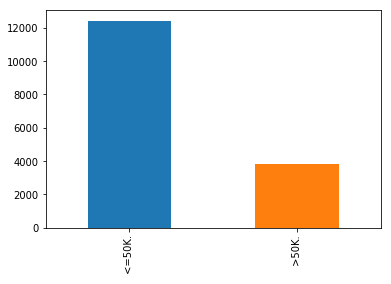

In [35]:
# Visualize the count of our labels
adults_test_filtered.SalaryCategory.value_counts().plot.bar()

In [36]:
# Check test labels shape
y_test_lb.shape

(16280,)

In [37]:
# Apply test inputs to model
y_pred_test = tl.utils.predict(sess, network, X_test_scaled, x=x, y_op=y_op)

In [38]:
# Get metrics from test vs predicted test labels such as accuracy, f1-score, and the confusion matrix
results_test = tl.utils.evaluation(y_test_lb, y_pred_test, n_classes=2)

[TL] confusion matrix: 
[[11801   633]
 [ 2412  1434]]
[TL] f1-score        : [0.88572822 0.48503298]
[TL] f1-score(macro) : 0.685381
[TL] accuracy-score  : 0.812961


In [39]:
# save  the model
tl.files.save_npz_dict(train_params,name='adult_ann_basic.npz',sess=sess)

[TL] [*] Model saved in npz_dict adult_ann_basic.npz


In [40]:
# Close the session. Don't forget to do this for the interactive sessions.
sess.close()

# Practice Exercises

* Implement your own ANN with TensorLayer on a data set of your choice.
* Read through the [examples in the TensorLayer documentation](https://tensorlayer.readthedocs.io/en/stable/user/examples.html).
* Build another neural network of your choice with TensorLayer.

# Summary

* TensorLayer can serve as an easier means of using and/or transitioning into TensorFlow
* You now have an example of how to build an Artifical Neural Network with TensorLayer 


# Thanks for watching/reading! Let me know if you found this helpful by hitting
# 'like' on the video and subscribing to my Youtube Channel.

* [Video Tutorial](https://www.youtube.com/watch?v=sDKH2452IR8&feature=youtu.be&hd=1)
* [GitHub](http://github.com/johndeJesus22)
* [Twitter](https://twitter.com/johnnydata22)
* [LinkedIn](https://www.linkedin.com/in/jdejesus22/)
